### e-ratio drivers using SMYLE-FOSI

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

import cftime

import utils

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

In [2]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [3]:
ds_fosi_seas = xr.Dataset()

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

In [5]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
delta = cftime.DatetimeNoLeap(1958, 1, 31, 0, 0, 0, 0) - cftime.DatetimeNoLeap(306, 1, 31, 0, 0, 0, 0)

outdir = '/glade/scratch/kristenk/SMYLE_paper/'

### get the vars

In [6]:
for var in ['POC_FLUX_100m','photoC_TOT_zint_100m','HMXL','SHF_QSW','TEMP','diatC','spC','diazC','photoC_diat_zint_100m']:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_fosi = xr.open_dataset(obs_dir+'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.'+var+'.030601-036812.nc')
    ds_fosi['time'] = ds_fosi.time + delta #offset for JRA cycle to historical
    datetimeindex = ds_fosi.indexes['time'].to_datetimeindex()
    ds_fosi['time'] = datetimeindex
    ds_fosi = ds_fosi.sel(time=slice("1960","2020"))
    

    if var=='TEMP':
        ds_fosi[var] = ds_fosi.TEMP.isel(z_t=slice(0,10)).mean(dim='z_t')
        
    if var=='diatC':
        ds_fosi[var] = (ds_fosi.diatC * 10).sum(dim='z_t_150m')
        
    if var=='diazC':
        ds_fosi[var] = (ds_fosi.diazC * 10).sum(dim='z_t_150m')
        
    if var=='spC':
        ds_fosi[var] = (ds_fosi.spC * 10).sum(dim='z_t_150m')
    
    #### make seasonal
    ds_fosi_seas[var] = obs_convert_mon_to_seas(ds_fosi[var],var).sel(year=slice("1960","2020"))[var]
    
    print('fosi done')
    
    

starting on  POC_FLUX_100m
fosi done
starting on  photoC_TOT_zint_100m
fosi done
starting on  HMXL
fosi done
starting on  SHF_QSW
fosi done
starting on  TEMP
fosi done
starting on  diatC
fosi done
starting on  spC
fosi done
starting on  diazC
fosi done
starting on  photoC_diat_zint_100m
fosi done


### calculate e-ratio, diat frac, tot phytoC

In [7]:
ds_fosi_seas['eratio'] = ds_fosi_seas['POC_FLUX_100m']/ds_fosi_seas['photoC_TOT_zint_100m']

In [8]:
ds_fosi_seas['phytoC'] = ds_fosi_seas['diatC'] + ds_fosi_seas['spC'] + ds_fosi_seas['diazC']

In [9]:
ds_fosi_seas['diat_frac'] = ds_fosi_seas['diatC'] / ds_fosi_seas['phytoC']

In [10]:
variables = ['POC_FLUX_100m','photoC_TOT_zint_100m','HMXL',
             'SHF_QSW','TEMP','diatC','spC','diazC',
             'photoC_diat_zint_100m','diat_frac','eratio']

### Make these into anomalies

In [11]:
### make fosi into anomalies
ds_fosi_seas_anoms = ds_fosi_seas - ds_fosi_seas.sel(year=slice(1972,2017)).mean('year')

In [12]:
ds_fosi_seas_anoms #.season

<xarray.Dataset>
Dimensions:                (year: 61, nlat: 384, nlon: 320, season: 4)
Coordinates:
  * year                   (year) int64 1960 1961 1962 1963 ... 2018 2019 2020
    ULONG                  (nlat, nlon) float64 321.1 322.3 323.4 ... nan nan
    ULAT                   (nlat, nlon) float64 -78.95 -78.95 -78.95 ... nan nan
    TLONG                  (nlat, nlon) float64 320.6 321.7 322.8 ... nan nan
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan
  * season                 (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: nlat, nlon
Data variables:
    POC_FLUX_100m          (season, year, nlat, nlon) float64 nan nan ... nan
    photoC_TOT_zint_100m   (season, year, nlat, nlon) float64 nan nan ... nan
    HMXL                   (season, year, nlat, nlon) float64 nan nan ... nan
    SHF_QSW                (season, year, nlat, nlon) float64 nan nan ... nan
    TEMP                   (season, year, nlat, nlon) float64 nan nan ... nan
    diatC                  (season, year, nlat, nlon) float64 nan nan ... 0.0
    spC                    (season, year, nlat, nlon) float64 nan nan ... 0.0
    diazC                  (season, year, nlat, nlon) float64 nan nan ... 0.0
    photoC_diat_zint_100m  (season, year, nlat, nlon) float64 nan nan ... nan
    eratio                 (season, year, nlat, nlon) float64 nan nan ... nan
    phytoC                 (season, year, nlat, nlon) float64 nan nan ... 0.0
    diat_frac              (season, year, nlat, nlon) float64 nan nan ... nan

### get the grid

In [13]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
area = ds_grid.TAREA
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### create ones masking array and read in LMEs

In [14]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [15]:
file = '/glade/work/kristenk/fish-offline/fish-offline/notebooks/data/LME-mask-POP_gx1v6.nc'
ds_lme = xr.open_dataset(file)

### How much does the eratio vary for each season?

##### in the CA current

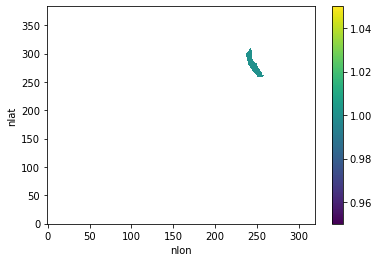

In [16]:
mask = ones.where(ds_lme.lme_mask==3)
mask.plot()

In [17]:
ca_current_ds_anoms = xr.Dataset()
ca_current_ds = xr.Dataset()
for var in variables:
    print(var)
    masked_area = area.where(mask==1)
    
    masked_fosi = ds_fosi_seas_anoms[var].where(mask==1)
    ca_current_ds_anoms[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    masked_fosi = ds_fosi_seas[var].where(mask==1)
    ca_current_ds[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

POC_FLUX_100m
photoC_TOT_zint_100m
HMXL
SHF_QSW
TEMP
diatC
spC
diazC
photoC_diat_zint_100m
diat_frac
eratio


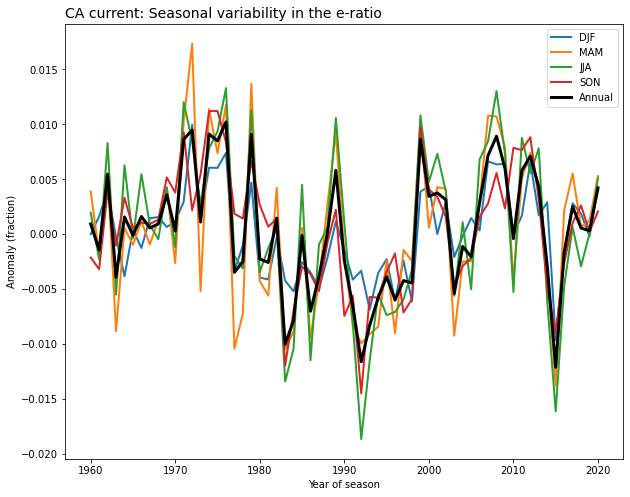

In [18]:
fig = plt.figure(figsize=(10,8))

xvals = np.arange(1,8,1)
#xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(1,1,1)
ax.set_title('CA current: Seasonal variability in the e-ratio',fontsize=14,loc='left')
ax.set_ylabel('Anomaly (fraction)')
ax.set_xlabel('Year of season')

for season in ca_current_ds_anoms.season.values:
    
    ax.plot(ca_current_ds.year,ca_current_ds_anoms.eratio.sel(season=season),
            label=season, lw=2)
## plot annual mean

ax.plot(ca_current_ds.year,ca_current_ds_anoms.eratio.mean(dim='season'),
            label='Annual', lw=3,color='black')
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

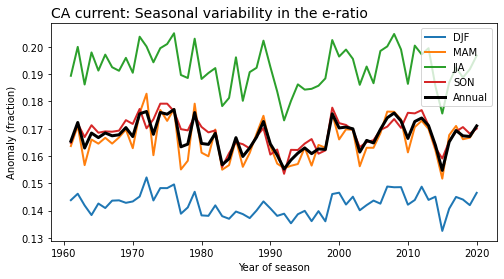

In [19]:
fig = plt.figure(figsize=(8,4))

xvals = np.arange(1,8,1)
#xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(1,1,1)
ax.set_title('CA current: Seasonal variability in the e-ratio',fontsize=14,loc='left')
ax.set_ylabel('Anomaly (fraction)')
ax.set_xlabel('Year of season')

for season in ca_current_ds.season.values:
    
    ax.plot(ca_current_ds.year.isel(year=slice(1,61)),ca_current_ds.eratio.sel(season=season).isel(year=slice(1,61)),
            label=season, lw=2)
## plot annual mean

ax.plot(ca_current_ds.year.isel(year=slice(1,61)),ca_current_ds.eratio.mean(dim='season').isel(year=slice(1,61)),
            label='Annual', lw=3,color='black')
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

### let's do some correlations

In [20]:
%%time

dict_season_eratio_CAcurr = {}
driver_vars = ['HMXL','SHF_QSW','TEMP','diat_frac','photoC_TOT_zint_100m','photoC_diat_zint_100m']

ds_djf = ca_current_ds_anoms.isel(season=0)
## remove first timeslice because it's all nans
ds_djf = ds_djf.isel(year=slice(1,61))
ds_mam = ca_current_ds_anoms.isel(season=1)
ds_jja = ca_current_ds_anoms.isel(season=2)
ds_son = ca_current_ds_anoms.isel(season=3)

ds_diat_corr1 = xr.Dataset()
ds_diat_corr2 = xr.Dataset()
ds_diat_corr3 = xr.Dataset()
ds_diat_corr4 = xr.Dataset()

for var in driver_vars:
    print(var)
    ds_diat_corr1[var] = xr.corr(ds_djf.eratio,ds_djf[var],dim='year')
    ds_diat_corr2[var] = xr.corr(ds_mam.eratio,ds_mam[var],dim='year')
    ds_diat_corr3[var] = xr.corr(ds_jja.eratio,ds_jja[var],dim='year')
    ds_diat_corr4[var] = xr.corr(ds_son.eratio,ds_son[var],dim='year')
    
dict_season_eratio_CAcurr['DJF'] = ds_diat_corr1
dict_season_eratio_CAcurr['MAM'] = ds_diat_corr2
dict_season_eratio_CAcurr['JJA'] = ds_diat_corr3
dict_season_eratio_CAcurr['SON'] = ds_diat_corr4

HMXL
SHF_QSW
TEMP
diat_frac
photoC_TOT_zint_100m
photoC_diat_zint_100m
CPU times: user 134 ms, sys: 1.8 ms, total: 135 ms
Wall time: 139 ms


In [21]:
dict_season_eratio_CAcurr['JJA']

<xarray.Dataset>
Dimensions:                ()
Coordinates:
    season                 <U3 'JJA'
Data variables:
    HMXL                   float64 -0.3281
    SHF_QSW                float64 0.2076
    TEMP                   float64 -0.8363
    diat_frac              float64 0.9535
    photoC_TOT_zint_100m   float64 0.7611
    photoC_diat_zint_100m  float64 0.9202

#### in SE US shelf

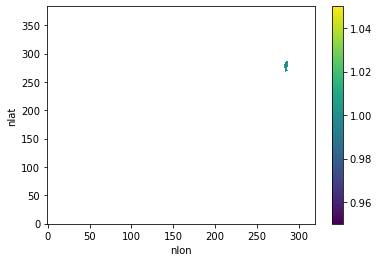

In [22]:
mask = ones.where(ds_lme.lme_mask==6)
mask.plot()

In [23]:
se_us_shelf_ds_anoms = xr.Dataset()
se_us_shelf_ds = xr.Dataset()
for var in variables:
    print(var)
    masked_area = area.where(mask==1)
    
    masked_fosi = ds_fosi_seas_anoms[var].where(mask==1)
    se_us_shelf_ds_anoms[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    masked_fosi = ds_fosi_seas[var].where(mask==1)
    se_us_shelf_ds[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

POC_FLUX_100m
photoC_TOT_zint_100m
HMXL
SHF_QSW
TEMP
diatC
spC
diazC
photoC_diat_zint_100m
diat_frac
eratio


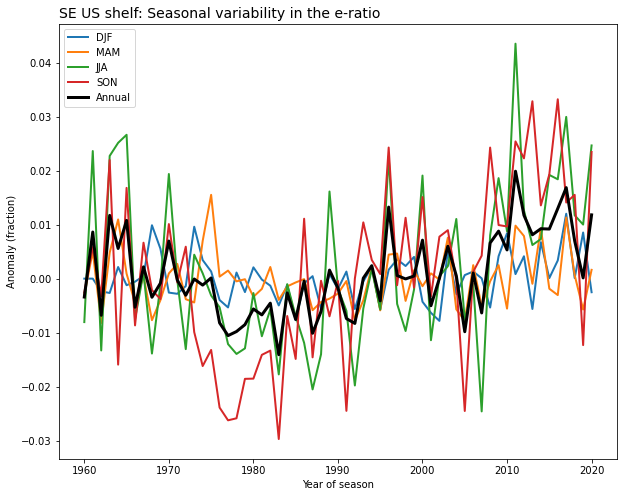

In [24]:
fig = plt.figure(figsize=(10,8))

xvals = np.arange(1,8,1)
#xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(1,1,1)
ax.set_title('SE US shelf: Seasonal variability in the e-ratio',fontsize=14,loc='left')
ax.set_ylabel('Anomaly (fraction)')
ax.set_xlabel('Year of season')

for season in se_us_shelf_ds_anoms.season.values:
    
    ax.plot(se_us_shelf_ds_anoms.year,se_us_shelf_ds_anoms.eratio.sel(season=season),
            label=season, lw=2)
## plot annual mean

ax.plot(se_us_shelf_ds_anoms.year,se_us_shelf_ds_anoms.eratio.mean(dim='season'),
            label='Annual', lw=3,color='black')
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

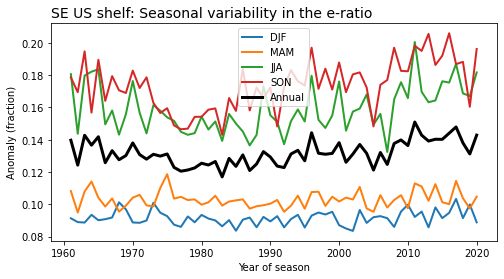

In [25]:
fig = plt.figure(figsize=(8,4))

xvals = np.arange(1,8,1)
#xlabs = ['JJA','SON','DJF','MAM','JJA','SON','DJF']

ax = fig.add_subplot(1,1,1)
ax.set_title('SE US shelf: Seasonal variability in the e-ratio',fontsize=14,loc='left')
ax.set_ylabel('Anomaly (fraction)')
ax.set_xlabel('Year of season')

for season in se_us_shelf_ds.season.values:
    
    ax.plot(se_us_shelf_ds.year.isel(year=slice(1,61)),se_us_shelf_ds.eratio.sel(season=season).isel(year=slice(1,61)),
            label=season, lw=2)
## plot annual mean

ax.plot(se_us_shelf_ds.year.isel(year=slice(1,61)),se_us_shelf_ds.eratio.mean(dim='season').isel(year=slice(1,61)),
            label='Annual', lw=3,color='black')
#plt.xticks(xvals, xlabs, rotation='vertical')
ax.legend();

In [26]:
%%time

dict_season_eratio_SEUSshelf = {}
driver_vars = ['HMXL','SHF_QSW','TEMP','diat_frac','photoC_TOT_zint_100m','photoC_diat_zint_100m']

ds_djf = se_us_shelf_ds_anoms.isel(season=0)
## remove first timeslice because it's all nans
ds_djf = ds_djf.isel(year=slice(1,61))
ds_mam = se_us_shelf_ds_anoms.isel(season=1)
ds_jja = se_us_shelf_ds_anoms.isel(season=2)
ds_son = se_us_shelf_ds_anoms.isel(season=3)

ds_diat_corr1 = xr.Dataset()
ds_diat_corr2 = xr.Dataset()
ds_diat_corr3 = xr.Dataset()
ds_diat_corr4 = xr.Dataset()

for var in driver_vars:
    print(var)
    ds_diat_corr1[var] = xr.corr(ds_djf.eratio,ds_djf[var],dim='year')
    ds_diat_corr2[var] = xr.corr(ds_mam.eratio,ds_mam[var],dim='year')
    ds_diat_corr3[var] = xr.corr(ds_jja.eratio,ds_jja[var],dim='year')
    ds_diat_corr4[var] = xr.corr(ds_son.eratio,ds_son[var],dim='year')
    
dict_season_eratio_SEUSshelf['DJF'] = ds_diat_corr1
dict_season_eratio_SEUSshelf['MAM'] = ds_diat_corr2
dict_season_eratio_SEUSshelf['JJA'] = ds_diat_corr3
dict_season_eratio_SEUSshelf['SON'] = ds_diat_corr4

HMXL
SHF_QSW
TEMP
diat_frac
photoC_TOT_zint_100m
photoC_diat_zint_100m
CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 142 ms


In [27]:
dict_season_eratio_SEUSshelf['SON']

<xarray.Dataset>
Dimensions:                ()
Coordinates:
    season                 <U3 'SON'
Data variables:
    HMXL                   float64 0.09501
    SHF_QSW                float64 0.03347
    TEMP                   float64 0.2741
    diat_frac              float64 0.9478
    photoC_TOT_zint_100m   float64 -0.6265
    photoC_diat_zint_100m  float64 0.3059

### Gulf of Mexico

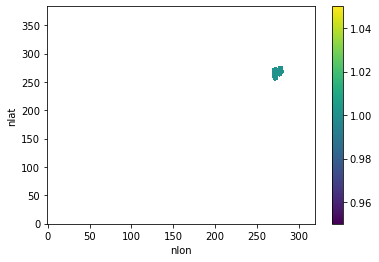

In [28]:
mask = ones.where(ds_lme.lme_mask==5)
mask.plot()

In [29]:
se_us_shelf_ds_anoms = xr.Dataset()
se_us_shelf_ds = xr.Dataset()
for var in variables:
    print(var)
    masked_area = area.where(mask==1)
    
    masked_fosi = ds_fosi_seas_anoms[var].where(mask==1)
    se_us_shelf_ds_anoms[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    masked_fosi = ds_fosi_seas[var].where(mask==1)
    se_us_shelf_ds[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

POC_FLUX_100m
photoC_TOT_zint_100m
HMXL
SHF_QSW
TEMP
diatC
spC
diazC
photoC_diat_zint_100m
diat_frac
eratio


### Do it on a gridcell basis

### Make a dictionary for correlations for each season

In [30]:
dict_season_eratio = {}
driver_vars = ['HMXL','SHF_QSW','TEMP','diat_frac','phytoC','photoC_TOT_zint_100m','photoC_diat_zint_100m']

### find the main drivers for production in each season

In [31]:
ds_djf = ds_fosi_seas.isel(season=0)
## remove first timeslice because it's all nans
ds_djf = ds_djf.isel(year=slice(1,61))
ds_mam = ds_fosi_seas.isel(season=1)
ds_jja = ds_fosi_seas.isel(season=2)
ds_son = ds_fosi_seas.isel(season=3)

In [32]:
%%time

ds_diat_corr1 = xr.Dataset()
ds_diat_corr2 = xr.Dataset()
ds_diat_corr3 = xr.Dataset()
ds_diat_corr4 = xr.Dataset()

for var in driver_vars:
    print(var)
    ds_diat_corr1[var] = xr.corr(ds_djf.eratio,ds_djf[var],dim='year')
    ds_diat_corr2[var] = xr.corr(ds_mam.eratio,ds_mam[var],dim='year')
    ds_diat_corr3[var] = xr.corr(ds_jja.eratio,ds_jja[var],dim='year')
    ds_diat_corr4[var] = xr.corr(ds_son.eratio,ds_son[var],dim='year')
    
dict_season_eratio['DJF'] = ds_diat_corr1
dict_season_eratio['MAM'] = ds_diat_corr2
dict_season_eratio['JJA'] = ds_diat_corr3
dict_season_eratio['SON'] = ds_diat_corr4

HMXL
SHF_QSW
TEMP
diat_frac
phytoC
photoC_TOT_zint_100m
photoC_diat_zint_100m
CPU times: user 10.4 s, sys: 2.74 s, total: 13.1 s
Wall time: 14.2 s


In [ ]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('e-ratio drivers JJA')


ax = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) HMXL', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].HMXL)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) SHF_QSW', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].SHF_QSW)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) TEMP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].TEMP)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) NPP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].photoC_TOT_zint_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('e) Diatom fraction', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].diat_frac)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('f) Diatom NPP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['JJA'].photoC_diat_zint_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='correlation',extend='both')

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('e-ratio drivers DJF')


ax = fig.add_subplot(3,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) HMXL', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].HMXL)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) SHF_QSW', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].SHF_QSW)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) TEMP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].TEMP)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) NPP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].photoC_TOT_zint_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('e) Diatom fraction', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].diat_frac)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(3,2,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('f) Diatom NPP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dict_season_eratio['DJF'].photoC_diat_zint_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.8,vmax=0.8,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='correlation',extend='both')